# South Korea

This notebook contains all the Julia 1.4.x code required to characterize the 
propagation of CoViD19 as discussed in the main notebook:
 _Population_dynamics.ipynb_

Here we use simple _logistic_ like models, based only on the total number of 
infected cases, for more robust and elaborate models consider the SIR_like 
notebooks found in this folder.

### Initialization, display LOAD_PATH at the end

In [1]:
push!(LOAD_PATH, pwd())
if ispath( pwd()*"/src")
    push!(LOAD_PATH, pwd()*"/src")
end


using SpecialFunctions, LaTeXStrings
using DataFrames, Query, CSV, Dates
using LsqFit

using MyFunctions, Mrate

using Plots
# plotly();
theme( :gruvbox_light );
mysize = ( Int( round( 400 *MathConstants.golden ) ), 400 );

### Parametrization for the incubation times, source:
https://doi.org/10.2807/1560-7917.ES.2020.25.5.2000062

In [2]:
μΓ, σΓ = 6.5, 2.6;      # mean and standard deviation for incubation

αΓ( μ, σ ) = μ^2/σ^2;   # [α] = 1  is a dimensionless parameter
βΓ( μ, σ ) = μ / σ^2    # [β] = 1/T has dimension of frequency

α0 = αΓ( μΓ, σΓ );
β0 = βΓ( μΓ, σΓ );

ρ0=[α0,β0];

### load data and manipulate data

In [3]:
path = pwd()*"/datahub.io/covid-19/data";
path_data = path*"/time-series-19-covid-combined.csv";
path_ref  = path*"/reference.csv";

raw_data = CSV.File( path_data ) |> DataFrame!;
col_names = names( raw_data )

col_names[2] = "CountryRegion";
col_names[3] = "ProvinceState";
rename!( raw_data, col_names );

In [4]:
country_names =  unique( raw_data[!,2] );
country_name = "Korea, South";
country = raw_data |> @filter( _.CountryRegion==country_name
    ) |> DataFrame;

In [5]:
dates = Date.( country[!,:Date] );

confirmed_int = convert( Array{Number}, country[!,:Confirmed] );
recovered_int = convert( Array{Number}, country[!,:Recovered] );
deaths_int    = convert( Array{Number}, country[!,:Deaths   ] );

In [6]:
d1   = findfirst( >=(1  ), confirmed_int );
d10  = findfirst( >=(10 ), confirmed_int );
d20  = findfirst( >=(20 ), confirmed_int );
d50  = findfirst( >=(50 ), confirmed_int );
d100 = findfirst( >=(100), confirmed_int );

read raw data and basic processing

In [7]:
raw_ref  = CSV.File( path_ref  ) |> DataFrame!;
ref_names = names( raw_ref )

IDs = convert( Vector, raw_ref[!,11] );

row_country = findall( isequal( country_name ), IDs );
country_name = "Korea_South"; # much easier to work with this!

@assert length( row_country ) == 1
population = convert.( Number, raw_ref[ row_country[1], 12 ] );

println( [ population, 1/population ]' )

[5.1269183e7 1.9504894392407227e-8]


In [8]:
#   set initial time and offset it to day of first registered infection
date_1 = dates[ d1 ]
data_last = dates[ end ]
days = float.( Dates.value.( dates -date_1 ) )

# normalize population
confirmed = confirmed_int ./ population;
recovered = recovered_int ./ population;
deaths    = deaths_int    ./ population;

# determine normalized sir time series
removed     = ( recovered +deaths  );
infected    = ( confirmed -removed );
susceptible = ( 1 .-infected .-removed );

#### visualize raw data

In [9]:
nM = 1.25 *maximum( confirmed )
nm = 0.75 *minimum( confirmed )


tm, tM = days[d1], maximum( days ) +5;

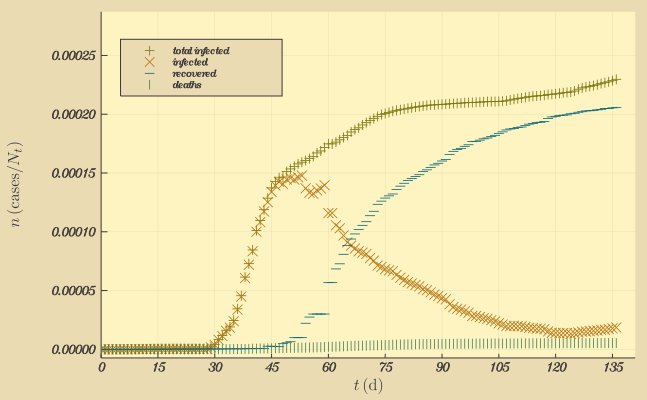

In [10]:
plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:topleft, legendfontsize=6, size=mysize )
plot!( days, infected, label="infected"
    , markershape=:xcross, markersize=5, linealpha=0 )
plot!( days, recovered, label="recovered"
    , markershape=:hline, markersize=5, linealpha=0 )
plot!( days, deaths, label="deaths"
    , markershape=:vline, markersize=5, linealpha=0 )

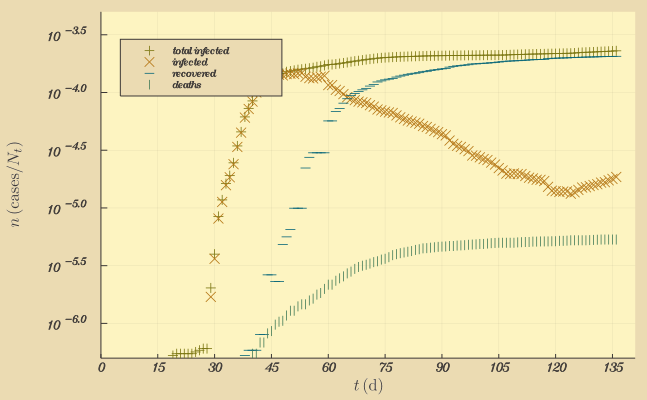

In [11]:
plot!( yscale = :log10, ylims = (5e-7,5e-4) )

In [12]:
plot!( yscale = :auto, ylims = (-500*nm,nM) );

### The models
__Note:__ parameter p[2] is not multiplied by p[1] as in the main notes. Here p[2] is dimensionless! To recover the definition used in the main text divide by p[1], ie t_0 = p[2]/p[1]

In [13]:
# simple logistic model
@. model0(t,p) = 1/( 1.0 +exp( -p[1]*t +p[2] ) );

In [14]:
# the m-steady state model and its Jacobian
# definitions of modelm, modelm_j and all other relevant functions
# at Mrate.jl and MyFunctions.jl

function m_m( t, p )
    modelm(t,p,ρ0)
end;

function j_m(t::Array,p)
    J = Array{Float64}(undef, length(t), length(p))
    J = modelm_j(t, p, ρ0)
end;

In [15]:
p0 = [0.25, 0. ];
x0 = [0, 1.0, 2.0];
model0(0.0, p0);
model0(x0, p0);
m_m(0.0,p0);
m_m(x0,p0);
j_m(x0,p0);

### Nonlinear fits
#### The logistic fit

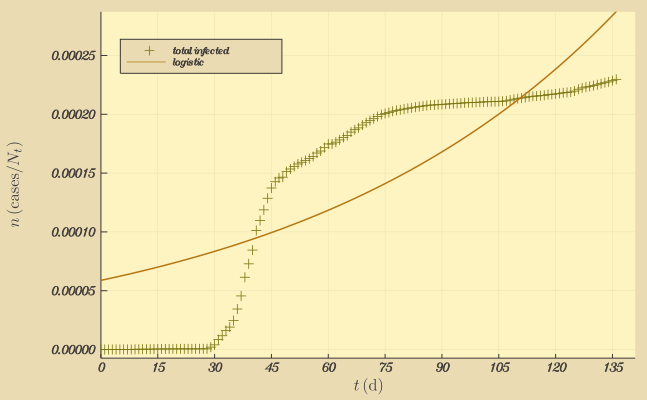

In [16]:
t_offset, d_off = date_1, d1
tcont = range(days[1],days[end]*1.1; length=3*length(days))

dm, dM = d1, length(days);
xdata = days[dm:dM]; ydata = confirmed[dm:dM];


fit0 = curve_fit( model0, xdata, ydata, p0 )
estimate0 = model0( tcont, fit0.param )

# half population time and date
t12 = floor( fit0.param[2]/fit0.param[1] )
t_offset +Dates.Day( t12 )

plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:topleft, legendfontsize=6, size=mysize )

plot!( tcont, estimate0, label="logistic", linewidth=1.5 )

[0.159 15.9]


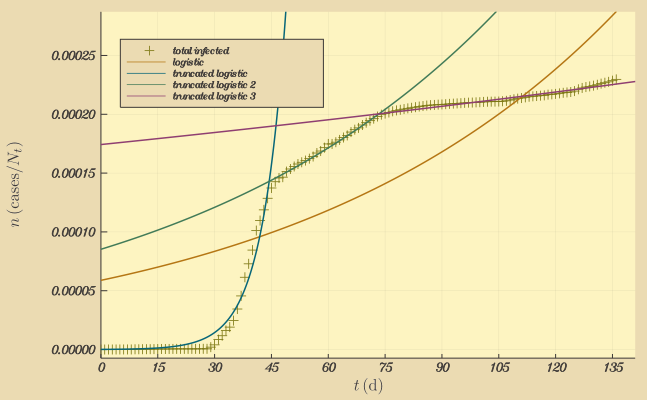

In [17]:
# ------------------------------------ #
#
#   truncated logistic 1
# 
dm, dM = d_off, d_off+45; p0 = [1., 45]
xdata = days[dm:dM]; ydata = confirmed[dm:dM];

fit0b = curve_fit( m_m, j_m, xdata, ydata, p0; )
estimate0b = m_m( tcont, fit0b.param )

println( round.( fit0b.param'; sigdigits=3 )  )

# half population time and date
t12 = floor( fit0b.param[2]/fit0b.param[1] )
t_offset +Dates.Day( t12 )


# ------------------------------------ #
#
#   truncated logistic 2
# 
dm, dM = d_off+45, d_off+75;
xdata = days[dm:dM]; ydata = confirmed[dm:dM];

fit0c = curve_fit( m_m, j_m, xdata, ydata, p0 )
estimate0c = m_m( tcont, fit0c.param )


fit0c.param


# ------------------------------------ #
#
#   truncated logistic 3
# 
dm, dM = d_off+85, length(days);
xdata = days[dm:dM]; ydata = confirmed[dm:dM];

fit0d = curve_fit( m_m, j_m, xdata, ydata, [0.001, 10.] )
estimate0d = m_m( tcont, fit0d.param )



plot!( tcont, estimate0b, linewidth = 1.5, label="truncated logistic"  )
plot!( tcont, estimate0c, linewidth = 1.5, label="truncated logistic 2" )
plot!( tcont, estimate0d, linewidth = 1.5, label="truncated logistic 3" )

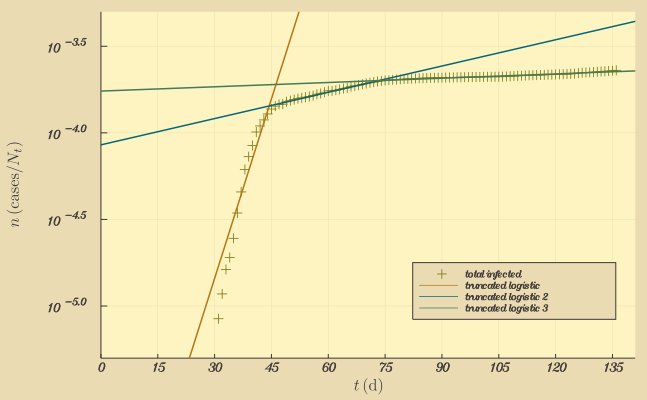

In [18]:
savefig("img/"*country_name*"_truncated.svg")


plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:bottomright, legendfontsize=6, size=mysize )
plot!( tcont, estimate0b, linewidth = 1.5, label="truncated logistic"  )
plot!( tcont, estimate0c, linewidth = 1.5, label="truncated logistic 2" )
plot!( tcont, estimate0d, linewidth = 1.5, label="truncated logistic 3" )
plot!( yscale = :log10, ylims = (5e-6, 5e-4) )

In [19]:
savefig("img/"*country_name*"_truncated_log.svg")
plot!( yscale = :auto, ylims = (nm,nM) );

#### two steady state model m=1

[0.188 17.0 0.00359 37.9]
[0.258 19.6 0.0115 35.0]
Date[2020-02-28, 2020-02-26]


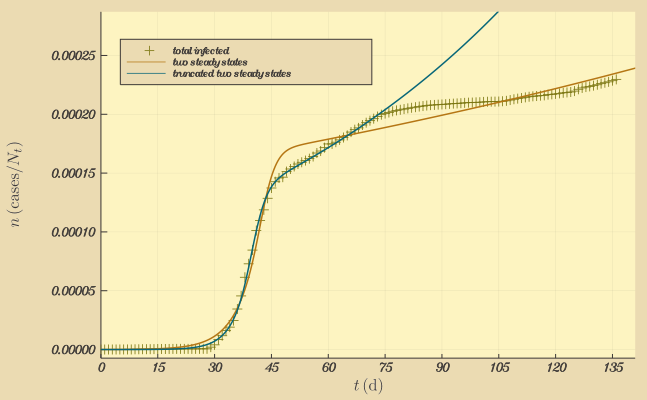

In [20]:
# ------------------------------------ #
# 
#   two rate steady state m = 1
# 
dm, dM = d_off, length(days); p1 = [0.2, 15, 0.05, 50 ];
xdata = days[dm:dM]; ydata = confirmed[dm:dM];

fit1 = curve_fit( m_m, j_m, xdata, ydata, p1 )
estimate1 = m_m( tcont, fit1.param )

println( round.( fit1.param'; sigdigits=3 )  )


# ------------------------------------ #
# 
#   truncated two rate steady state m = 1
# 
dm, dM = d_off, d_off+75; p1 = [0.2, 15, 0.05, 70 ];
xdata = days[dm:dM]; ydata = confirmed[dm:dM];

fit1b = curve_fit( m_m, j_m, xdata, ydata, p1 )
estimate1b = m_m( tcont, fit1b.param )

fit1b.param[2]/fit1b.param[1]
t12 = floor( fit1b.param[2]/fit1b.param[3] )
t_offset +Dates.Day( t12 )
t_offset +Dates.Day( floor( fit1b.param[4] ) )

println( round.( fit1b.param'; sigdigits=3 )  )


# transition date (day)
println( t_offset +Dates.Day.( floor.( [ fit1.param[4],fit1b.param[4] ] )) )


plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:topleft, legendfontsize=6, size=mysize )
plot!( tcont, estimate1, linewidth=1.5
    , label="two steady states" )

plot!( tcont, estimate1b, linewidth=1.5
    , label="truncated two steady states" )

#### three steady state m=2

[0.261 19.7 0.012 34.9 0.00183 66.4]
[0.261 19.7 0.012 34.9 0.00183 66.4]


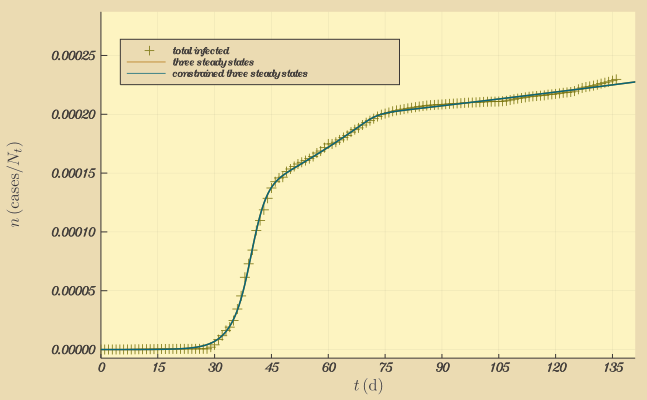

In [21]:
# ------------------------------------ #
# 
#   three rate steady state m = 2
# 
dm, dM = d_off, length(days); p2 = [0.25, 15, 0.01, 45, 0.005, 75 ]
xdata = days[dm:dM]; ydata = confirmed[dm:dM];

fit2 = curve_fit( m_m, j_m, xdata, ydata, p2 )
estimate2 = m_m( tcont, fit2.param );
println( round.( fit2.param'; sigdigits=3 ) )

# ------------------------------------ #
# 
#   constrained three rate steady state m = 2
# 
lb = [ 0.1, 1   , 0.005, 30, 0.00001, 65 ];
ub = [ 0.3, 1000, 0.1  , 45, 0.1    , 75 ];
fit2b = curve_fit( m_m, j_m, xdata, ydata, p2; lower=lb, upper=ub )

estimate2b = m_m( tcont, fit2b.param )
println( round.( fit2b.param'; sigdigits=3 ) )


plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:topleft, legendfontsize=6, size=mysize )
plot!( tcont, estimate2, linewidth=1.5, label="three steady states" )
plot!( tcont, estimate2b, linewidth=1.5, label="constrained three steady states" )

In [ ]:
# transition dates
println( t_offset +Dates.Day.( floor.( fit2b.param[4:2:length(p2)]' ) ) )

In [ ]:
# doubling times for each rate

println( round.( log(2) ./fit2b.param[1:2:length(p2)]'; sigdigits=3 ) )

#### four steady state m=3

[0.25, 15.0, 0.01, 45.0, 0.005, 75.0, 0.009, 95.0]
[0.26 19.7 0.0118 35.0 0.00142 67.6 0.00371 114.0]
[0.26 19.7 0.0118 35.0 0.00142 67.6 0.00371 114.0]


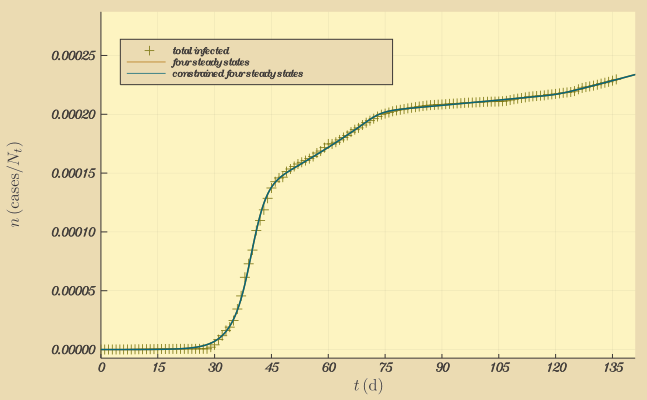

In [39]:
# ------------------------------------ #
# 
#   four rate steady state m = 3
# 
dm, dM = d_off, length(days); p3 = [0.25, 15, 0.01, 45, 0.005, 75, 0.009, 95 ]
xdata = days[dm:dM]; ydata = confirmed[dm:dM];

fit3 = curve_fit( m_m, j_m, xdata, ydata, p3 )
estimate3 = m_m( tcont, fit3.param );
println( round.( p3; sigdigits=3 ) )
println( round.( fit3.param'; sigdigits=3 ) )


# ------------------------------------ #
# 
#   constrained four rate steady state m = 3
# 
lb = [ 0.1, 1   , 0.005, 30, 0.00001, 65, 0.00001, 75 ];
ub = [ 0.3, 1000, 0.1  , 45, 0.1    , 75, 0.1    , 135 ];
fit3b = curve_fit( m_m, j_m, xdata, ydata, p3; lower=lb, upper=ub )

estimate3b = m_m( tcont, fit3b.param )
println( round.( fit3b.param'; sigdigits=3 ) )


plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:topleft, legendfontsize=6, size=mysize )
plot!( tcont, estimate3, linewidth=1.5, label="four steady states" )
plot!( tcont, estimate3b, linewidth=1.5, label="constrained four steady states" )

# Combined plot and fit quality

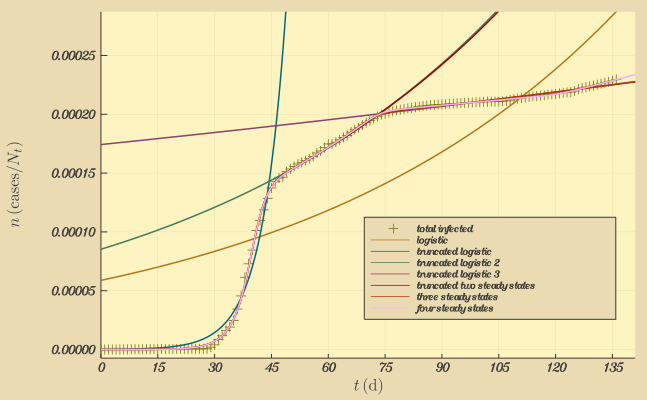

In [40]:
plot( days, confirmed, label="total infected"
    , shape=:cross, msize=5, lα=0
    , xlabel = L"t \, \mathrm{(d)}", xlims = (0,tM), xticks = 0:15:tM
    , ylabel = L"n \, (\mathrm{cases}/N_t)", ylims = (-500*nm,nM)
    , legend=:bottomright, legendfontsize=6, size=mysize )

plot!( tcont, estimate0, label="logistic", linewidth=1.5 )

plot!( tcont, estimate0b, linewidth = 1.5, label="truncated logistic"  )
plot!( tcont, estimate0c, linewidth = 1.5, label="truncated logistic 2" )
plot!( tcont, estimate0d, linewidth = 1.5, label="truncated logistic 3" )

plot!( tcont, estimate1b, linewidth=1.5, label="truncated two steady states" )

plot!( tcont, estimate2, linewidth=1.5, label="three steady states" )

plot!( tcont, estimate3, linewidth=1.5, label="four steady states" )

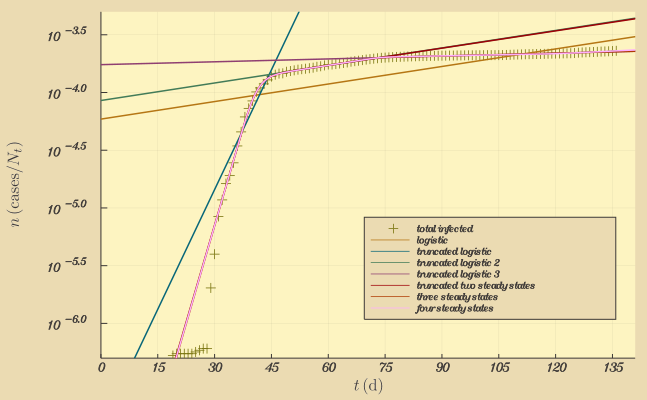

In [41]:
savefig("img/"*country_name*"_fits_converged.svg")
plot!( yscale = :log10, ylims = (5e-7, 5e-4) )

In [42]:
savefig("img/"*country_name*"_fits_converged_log.svg")
plot!( yscale = :auto, ylims = (nm,nM) );

##### Estimate quality of fit

In [43]:
myfit = fit3

cov_mat = estimate_covar(myfit)
sigma = stderror(myfit)

margin_of_error = margin_error(myfit, 0.05)

aux = confidence_interval(myfit, 0.05)
confidence_inter = zeros(2,6)
for i=1:length(p2)
    confidence_inter[:,i] = collect( aux[i] )
end


# display the parameters
println( round.( myfit.param; sigdigits=3 )' )

[0.26 19.7 0.0118 35.0 0.00142 67.6 0.00371 114.0]


In [45]:
# estimate the margins of error
println( round.( sigma; sigdigits=3 )' )

[0.00552 0.209 0.000183 0.0951 7.54e-5 0.367 0.000384 1.99]


In [44]:
# estimate the margins of error
println( round.( margin_of_error; sigdigits=3 )' )

[0.0109 0.414 0.000363 0.188 0.000149 0.726 0.000759 3.93]


In [32]:
# estimate the margins of error
round.( confidence_inter; sigdigits=3 )

2×6 Array{Float64,2}:
 0.249  19.2  0.0115  34.8  0.00127  66.8
 0.271  20.1  0.0122  35.2  0.00157  68.3

In [33]:
# the covariance matrix estimate
round.( cov_mat; sigdigits=3 )

8×8 Array{Float64,2}:
  3.05e-5    0.00115   2.15e-7  -0.000464  …  -0.000225   3.38e-9    6.33e-5
  0.00115    0.0437    7.7e-6   -0.0172       -0.00806    1.21e-7    0.00227
  2.15e-7    7.7e-6    3.36e-8  -7.4e-6       -4.98e-5    8.1e-10    1.52e-5
 -0.000464  -0.0172   -7.4e-6    0.00905       0.00797   -1.21e-7   -0.00226
  6.74e-9    2.41e-7   1.61e-9  -2.41e-7      -1.6e-5     4.39e-9    7.89e-5
 -0.000225  -0.00806  -4.98e-5   0.00797   …   0.135     -8.39e-6   -0.156
  3.38e-9    1.21e-7   8.1e-10  -1.21e-7      -8.39e-6    1.47e-7    0.000626
  6.33e-5    0.00227   1.52e-5  -0.00226      -0.156      0.000626   3.95